# Import

In [2]:
import numpy as np
from obspy.clients.fdsn import Client
from obspy import read, read_inventory, UTCDateTime
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import os

client = Client('IRIS')

---
# PSD with Mars raw data (BHU, BHV, BHW)

In [11]:
# Merge daily Mars continuous waveform

mseed_list = os.listdir("화성 연속파형/")

st = read("화성 연속파형/XB.ELYSE.02.BH1.202001010000.mseed")

for mseed in mseed_list:
    if mseed == 'XB.ELYSE.02.BH1.202001010000.mseed':
        continue
    if mseed == 'XB.ELYSE.02.BH1.202001080000.mseed':
        break

    merge = read("화성 연속파형/" + mseed)
    st = st + merge
    st.merge(fill_value= 'interpolate')

st

3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2020-01-01T00:00:00.031000Z - 2020-01-07T23:59:59.981000Z | 20.0 Hz, 12096000 samples
XB.ELYSE.02.BHV | 2020-01-01T00:00:00.031000Z - 2020-01-07T23:59:59.981000Z | 20.0 Hz, 12096000 samples
XB.ELYSE.02.BHW | 2020-01-01T00:00:00.031000Z - 2020-01-07T23:59:59.981000Z | 20.0 Hz, 12096000 samples

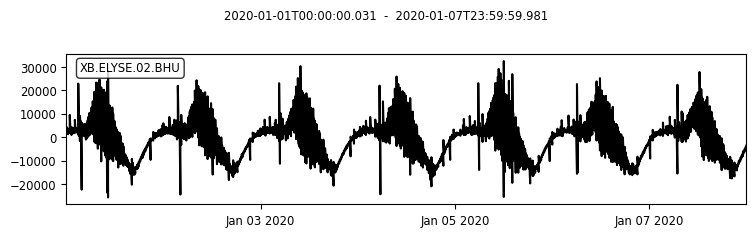

In [12]:
tr = st[0]
tr.plot();

In [13]:
# run PPSD to get Power spectral density from continuous waveform and save as npz format

inv = client.get_stations(starttime = UTCDateTime('2020-01-01T00:00:00.000'), endtime = UTCDateTime('2020-01-08T00:00:00.000'), 
                          network='XB', station='ELYSE', location='02', channel='BH*', level='response')

ppsd = PPSD(tr.stats, metadata= inv)
ppsd.add(tr)

ppsd.save_npz('mars_20200101_20200107.npz')

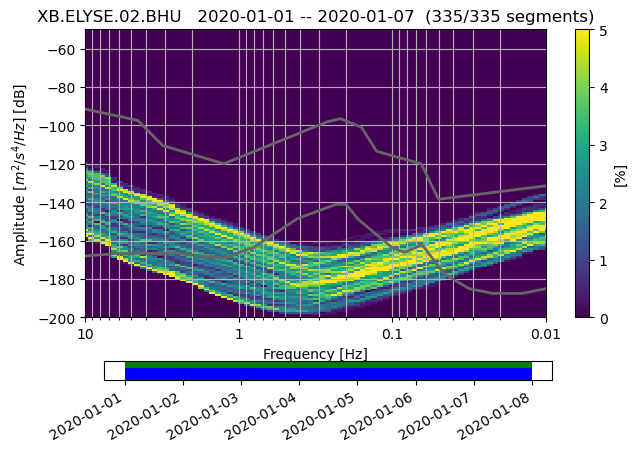

In [14]:
# plotting PPSD

example = PPSD.load_npz('mars_20200101_20200107.npz')
example.plot(xaxis_frequency=True, period_lim= (10, 0.01), max_percentage=5);

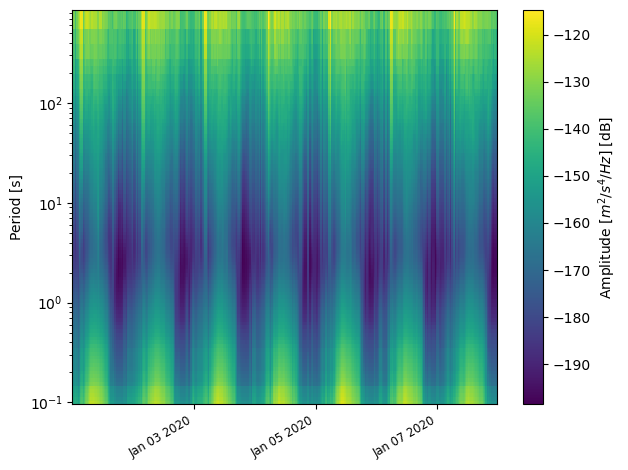

In [15]:
# plotting spectrogram with PSD

example.plot_spectrogram(grid=False);

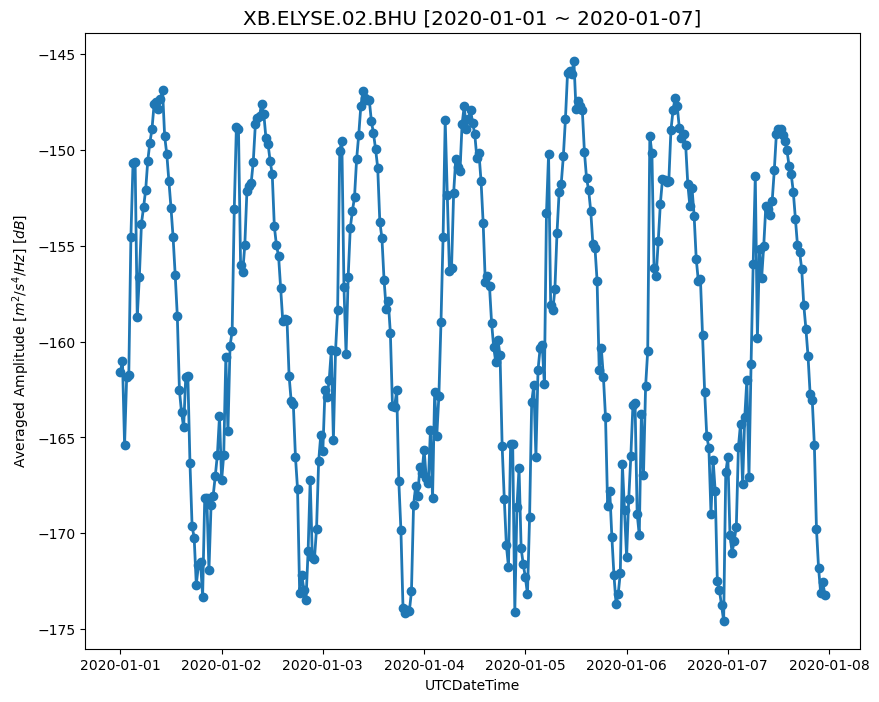

In [16]:
# Diurnal variation of averaged amplitude with each 1-hour windows 

import seaborn as sns
import matplotlib.dates as mdates

avg_amplitude = []
time = []

for i in range(len(example.psd_values)):
    time.append(UTCDateTime(int(str(example._times_processed[i])[:10])).matplotlib_date)
    avg_amplitude.append(example.psd_values[i].mean())

fig, ax = plt.subplots(figsize = (10, 8))
plt.style.use(['bmh'])
ax.plot(time, avg_amplitude, marker = 'o')
ax.set_xlabel('UTCDateTime')
ax.set_ylabel('Averaged Amplitude [$m^2 / s^4 / Hz$] [$dB$]')
ax.set_title('XB.ELYSE.02.BHU [2020-01-01 ~ 2020-01-07]')

xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

---

# (WIP) PSD with Mars preprocessed data (BHZ, BHN, BHE)

idea from here
https://github.com/UMD-InSight/InSight-seismic-data-downloader